In [64]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [65]:
import torch
import torch.nn as nn

In [66]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=48):
        super(Actor, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, action_dim),
            nn.ReLU()
        )
        
        # 初始化网络参数为均值0，方差1的正态分布
        for m in self.actor:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0., std=1)
                nn.init.constant_(m.bias, 1)

    def forward(self, state):
        return self.actor(state)


class Critic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=48):
        super(Critic, self).__init__()

        self.critic = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1)
        )

        # 初始化网络参数为均值0，方差1的正态分布
        for m in self.critic:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0., std=1)
                nn.init.constant_(m.bias, 1)

    def forward(self, state, action):
        return self.critic(torch.cat([state, action], dim=1))


In [67]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=48):
        super(ActorCritic, self).__init__()

        self.actor = Actor(state_dim, action_dim, hidden_size)
        self.critic = Critic(state_dim, action_dim, hidden_size)
        
    def forward(self, state):
        action = self.actor(state)
        value = self.critic(state, action)
        return action, value


In [68]:
import numpy as np
import torch
from torch import optim


class RunningMeanStd:
    # Dynamically calculate mean and std
    def __init__(self, shape):  # shape:the dimension of input data
        self.n = 0
        self.mean = np.zeros(shape)
        self.S = np.zeros(shape)
        self.std = np.sqrt(self.S)

    def update(self, x):
        x = np.array(x)
        self.n += 1
        if self.n == 1:
            self.mean = x
            self.std = x
        else:
            old_mean = self.mean.copy()
            self.mean = old_mean + (x - old_mean) / self.n
            self.S = self.S + (x - old_mean) * (x - self.mean)
            self.std = np.sqrt(self.S / self.n)


class RewardScaling:
    def __init__(self, shape, gamma):
        self.shape = shape  # reward shape=1
        self.gamma = gamma  # discount factor
        self.running_ms = RunningMeanStd(shape=self.shape)
        self.R = np.zeros(self.shape)

    def __call__(self, x):
        self.R = np.roll(self.gamma * self.R, 1)
        self.R[0] = x
        self.running_ms.update(self.R)
        x = x / (self.running_ms.std + 1e-8)  # Only divided std
        return x

    def reset(self):  # When an episode is done,we should reset 'self.R'
        self.R = np.zeros(self.shape)



In [69]:
class Generator:
    def __init__(self, state_dim=2, action_dim=2, hidden_size=48, learning_rate=0.001):
        self.model = ActorCritic(state_dim, action_dim, hidden_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.predicted_value = None
        self.state_dim = state_dim
        self.reward_scaling = RewardScaling(shape=1, gamma=0.99)
        

    def generate_params(self):
        state = torch.randn(self.state_dim).unsqueeze(0)
        predicted_params, value = self.model(state)
        predicted_params = predicted_params.detach().numpy()
        predicted_params = np.clip(predicted_params, 0, 4)
        self.predicted_value = value
        return predicted_params, value.item()

    def update(self, score):
        reward = torch.tensor(score)
        reward = self.reward_scaling(reward)

        # 计算actor和critic的损失
        actor_loss = -self.predicted_value
        # print('reward:', reward, 'predicted_value:', self.predicted_value)
        critic_loss = (reward - self.predicted_value) ** 2
        # print('actor_loss:', actor_loss, 'critic_loss:', critic_loss)

        # 计算总损失
        loss = actor_loss + critic_loss

        # 反向传播和优化
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return actor_loss.item(), critic_loss.item(), loss.item(), reward.item()

In [70]:
action_dim = 1
num_epochs = 10000
learning_rate = 1e-6
hidden_size = 4

In [71]:
generator = Generator(action_dim=action_dim, learning_rate=learning_rate, hidden_size=hidden_size)

In [72]:
def acquistion_function(x):
    score = -np.log((x - 1.25) ** 2 + 1) / 3
    return score.sum()

In [73]:
params, value = generator.generate_params()
params

array([[0.7396946]], dtype=float32)

In [74]:
score = acquistion_function(params)
score

-0.07714612

In [75]:
loss = generator.update(score)
loss

(-2.5514304637908936,
 2.4069360817726926,
 -0.14449438201820097,
 1.0000001296241632)

In [76]:
from tqdm import tqdm


paramss = []
scores = []
actor_losss = []
critic_losss = []
losss = []
values = []
rewards = []
with tqdm(total=num_epochs) as pbar:
    for epoch in range(num_epochs):
        generator.reward_scaling.reset()
        params, value = generator.generate_params()
        score = acquistion_function(params)
        actor_loss, critic_loss, loss, reward = generator.update(score)

        paramss.append(params)
        scores.append(score)
        actor_losss.append(actor_loss)
        critic_losss.append(critic_loss)
        values.append(value)
        losss.append(loss)
        rewards.append(reward)

        pbar.set_postfix({'loss': loss})
        pbar.set_postfix({'params': str(params)})
        pbar.update(1)

100%|██████████| 10000/10000 [00:34<00:00, 287.45it/s, params=[[0.19059318]]]


In [77]:
import numpy as np
from matplotlib import pyplot as plt

[2.769905, 4.0, 4.0, 2.5372972, 2.7113483, 4.0, 2.9901116, 3.6600237, 4.0, 4.0, 4.0, 1.2744062, 2.4323335, 4.0, 3.2599323, 1.1246173, 4.0, 3.0763013, 2.0203366, 4.0, 2.172196, 2.645178, 4.0, 4.0, 4.0, 1.2985761, 4.0, 3.9601407, 2.8552275, 4.0, 2.3212152, 2.9455256, 1.7324352, 3.005154, 4.0, 4.0, 4.0, 4.0, 2.7291262, 4.0, 1.2594414, 1.5739167, 3.8228886, 1.9909496, 0.38382828, 2.5788798, 4.0, 4.0, 0.1887505, 4.0, 2.9624047, 2.8197427, 3.6007667, 3.4098537, 4.0, 4.0, 2.0153275, 2.6175508, 4.0, 3.7633934, 3.3275423, 3.0556517, 3.1431036, 3.5710123, 3.5526757, 4.0, 3.988462, 3.7233198, 3.7307723, 4.0, 1.5916294, 3.4072936, 0.92642003, 1.771864, 1.523124, 4.0, 3.8557673, 4.0, 4.0, 2.6446784, 3.0109978, 4.0, 3.5593708, 0.16085398, 2.5010865, 3.267677, 4.0, 4.0, 4.0, 1.2107552, 0.91145164, 1.3418949, 0.24774563, 4.0, 4.0, 2.5474863, 4.0, 3.5674722, 3.3580024, 2.9274812, 4.0, 4.0, 2.407117, 2.3512974, 4.0, 4.0, 2.7593298, 4.0, 3.2265873, 4.0, 0.3849061, 2.2978916, 3.6682174, 2.5487304, 0.31988

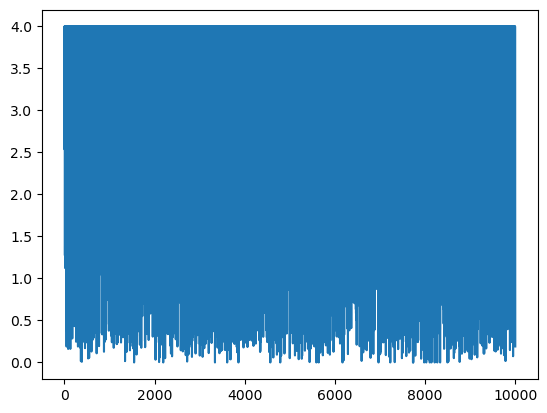

In [78]:
if action_dim == 1:
    paramss = [p[0][0] for p in paramss]
    print(paramss)
    plt.plot(paramss)
    plt.show()
elif action_dim == 2:
    paramss_np = np.array(paramss)
    print(paramss_np)
    plt.scatter(paramss_np[:, :, 0], paramss_np[:, :, 1], c=scores, cmap='viridis')
    plt.colorbar()
    plt.show()

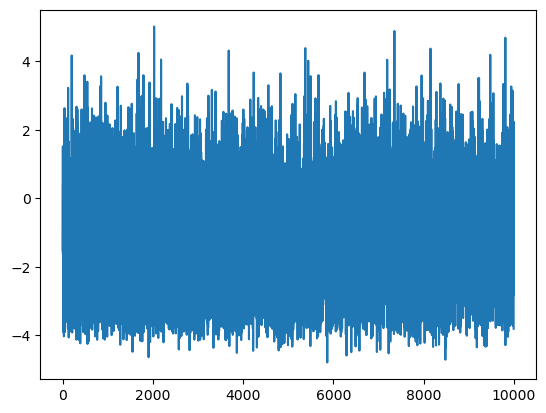

In [79]:
plt.plot(actor_losss)
plt.show()

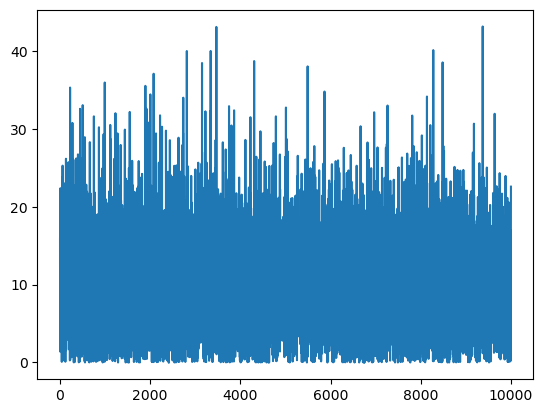

In [80]:
plt.plot(critic_losss)
plt.show()

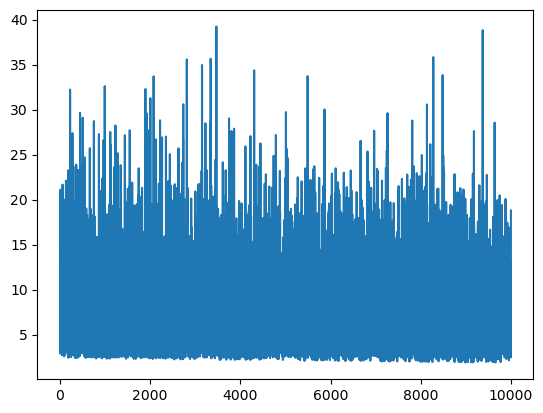

In [81]:
plt.plot(losss)
plt.show()

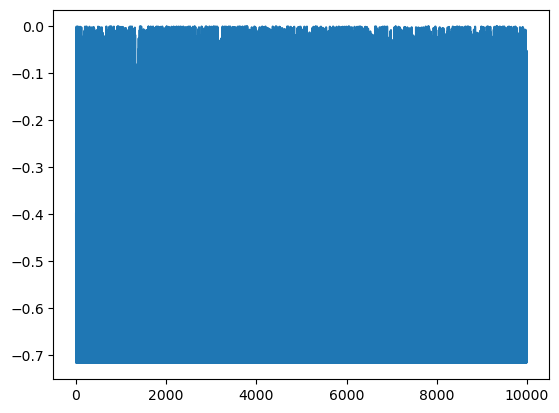

In [82]:
plt.plot(scores)
plt.show()

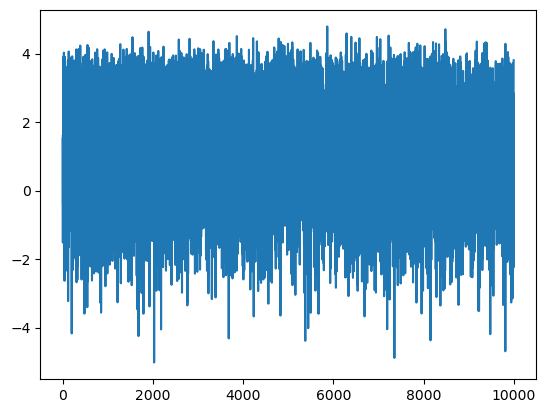

In [83]:
plt.plot(values)
plt.show()

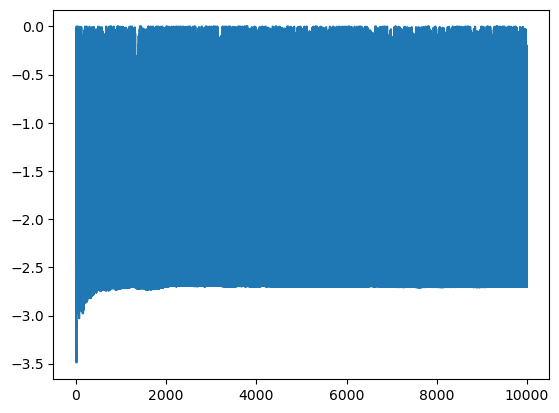

In [84]:
plt.plot(rewards)
plt.show()